<div align="center">

# Term Project

---

**Author:** Matthew Walczyk  
**Date:** 9/9/2024  
**Modified By:** Matthew Walczyk  
**Description:** Term project showing the use of a flat file, API, and website to gather data and then clean it and display it.

---
</div>

In [1]:
import requests
import sqlite3
import re
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mticker
from bs4 import BeautifulSoup
from matplotlib.dates import DateFormatter
from io import StringIO
from sqlalchemy import create_engine, text

In [2]:
# Load the CSV file
covid_data = pd.read_csv("https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv")

# Replacing headers with more readable names
covid_data.rename(columns={
    'iso_code': 'Country_Code',
    'continent': 'Continent',
    'location': 'Location',
    'date': 'Date',
    'total_cases': 'Total_Cases',
    'new_cases': 'New_Cases',
    'total_deaths': 'Total_Deaths',
    'new_deaths': 'New_Deaths',
    'total_vaccinations': 'Total_Vaccinations',
    'people_vaccinated': 'People_Vaccinated',
    'people_fully_vaccinated': 'People_Fully_Vaccinated'
}, inplace=True)

# Filter for United States data only
covid_data_us = covid_data[covid_data['Country_Code'] == 'USA']

# Convert Date column to datetime
covid_data_us['Date'] = pd.to_datetime(covid_data_us['Date'])

# Remove duplicate rows
covid_data_us.drop_duplicates(inplace=True)

# Removing rows with missing values in critical columns
covid_data_cleaned = covid_data_us.dropna(subset=['Total_Cases', 'New_Cases', 'Total_Deaths'])

# Fill missing values with 0 for non-critical columns
covid_data_cleaned.fillna({
    'Total_Vaccinations': 0,
    'People_Vaccinated': 0,
    'People_Fully_Vaccinated': 0
}, inplace=True)

# Convert Date to 'YYYY-MM-DD' format as a string
covid_data_cleaned['Date'] = covid_data_cleaned['Date'].dt.strftime('%Y-%m-%d')

# Display the first few rows of the cleaned US dataset
print(covid_data_cleaned.head())


       Country_Code      Continent       Location        Date  Total_Cases  \
403451          USA  North America  United States  2020-01-05          0.0   
403452          USA  North America  United States  2020-01-06          0.0   
403453          USA  North America  United States  2020-01-07          0.0   
403454          USA  North America  United States  2020-01-08          0.0   
403455          USA  North America  United States  2020-01-09          0.0   

        New_Cases  new_cases_smoothed  Total_Deaths  New_Deaths  \
403451        0.0                 NaN           0.0         0.0   
403452        0.0                 NaN           0.0         0.0   
403453        0.0                 NaN           0.0         0.0   
403454        0.0                 NaN           0.0         0.0   
403455        0.0                 NaN           0.0         0.0   

        new_deaths_smoothed  ...  male_smokers  handwashing_facilities  \
403451                  NaN  ...          24.6        

C:\Users\fclplb8\AppData\Local\Temp\ipykernel_43680\1934720033.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  covid_data_us['Date'] = pd.to_datetime(covid_data_us['Date'])
C:\Users\fclplb8\AppData\Local\Temp\ipykernel_43680\1934720033.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  covid_data_us.drop_duplicates(inplace=True)
C:\Users\fclplb8\AppData\Local\Temp\ipykernel_43680\1934720033.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/panda

In [3]:
# API setup and data request
api_key = "e41913d07db64c8183082da78b1396d2"  # Replace with your actual API key
url = f"https://api.covidactnow.org/v2/country/US.timeseries.json?apiKey={api_key}"
response = requests.get(url)
data = response.json()  

# Normalize JSON to a DataFrame
df_actuals = pd.json_normalize(data['actualsTimeseries'])
df_actuals['country'] = data['country']  # Adding country information

# 1. Replace Headers for Clarity
df_actuals.rename(columns={
    'cases': 'Total_Cases',
    'deaths': 'Total_Deaths',
    'newCases': 'Daily_New_Cases',
    'newDeaths': 'Daily_New_Deaths',
    'testPositivityRatio': 'Test_Positivity_Ratio',
    'icuCapacityRatio': 'ICU_Capacity_Ratio'
}, inplace=True)

# 2. Format Date for Consistency
df_actuals['date'] = pd.to_datetime(df_actuals['date'], errors='coerce')  # Coerce any bad dates to NaT

# 3. Identify Outliers and Handle Missing Values
# Interpolating NaN values for 'Daily_New_Cases' and 'Daily_New_Deaths'
df_actuals['Daily_New_Cases'] = df_actuals['Daily_New_Cases'].replace(0, np.nan).interpolate(method='linear')
df_actuals['Daily_New_Deaths'] = df_actuals['Daily_New_Deaths'].replace(0, np.nan).interpolate(method='linear')

# 4. Remove Duplicates
df_actuals.drop_duplicates(subset=['date'], inplace=True)  # Ensure unique entries per date

# 5. Add Rolling Averages and Other Derived Metrics
df_actuals['Daily_New_Cases_7day_Avg'] = df_actuals['Daily_New_Cases'].rolling(window=7, min_periods=1).mean()
df_actuals['Daily_New_Deaths_7day_Avg'] = df_actuals['Daily_New_Deaths'].rolling(window=7, min_periods=1).mean()

# Display sample data to confirm transformations
print("Transformed Data Sample:\n", df_actuals[['date', 'Total_Cases', 'Total_Deaths', 'Daily_New_Cases', 
                                                'Daily_New_Cases_7day_Avg', 'Daily_New_Deaths', 
                                                'Daily_New_Deaths_7day_Avg']].head(10))



Transformed Data Sample:
         date  Total_Cases  Total_Deaths  Daily_New_Cases  \
0 2020-03-09          NaN           NaN              NaN   
1 2020-03-10          NaN           NaN              NaN   
2 2020-03-11       1263.0          37.0              NaN   
3 2020-03-12       1668.0          43.0            403.0   
4 2020-03-13       2224.0          50.0            542.0   
5 2020-03-14       2897.0          60.0            673.0   
6 2020-03-15       3596.0          68.0            699.0   
7 2020-03-16       4502.0          91.0            906.0   
8 2020-03-17       5901.0         117.0           1398.0   
9 2020-03-18       8339.0         162.0           2591.5   

   Daily_New_Cases_7day_Avg  Daily_New_Deaths  Daily_New_Deaths_7day_Avg  
0                       NaN               NaN                        NaN  
1                       NaN               NaN                        NaN  
2                       NaN               NaN                        NaN  
3            

In [4]:
url = "https://en.wikipedia.org/wiki/COVID-19_pandemic_in_the_United_States"
response = requests.get(url, verify=False)
soup = BeautifulSoup(response.text, 'lxml')

html_string = StringIO(str(soup))
tables = pd.read_html(html_string)

cleaned_tables = []

for i, table in enumerate(tables):
    df = table.copy()
    
    # Skip tables that do not contain numeric data
    if not any(df.map(lambda x: isinstance(x, (int, float))).any()):
        continue

    # Clean headers by stripping whitespace and renaming columns for consistency
    df.columns = [str(col).strip() for col in df.columns]
    column_mapping = {
        'Date': 'Date',
        '# of cases': 'Total_Cases',
        '# of deaths': 'Total_Deaths'
    }
    df.rename(columns=column_mapping, inplace=True)

    # Replace common placeholders for missing data
    df.replace(["—", "N/A", "-", "unknown", "Unknown"], 0, inplace=True)

    # Clean numeric columns to retain only numbers (removing annotations like `(+48,152)`)
    for col in df.columns:
        if 'Cases' in col or 'Deaths' in col:
            df[col] = df[col].apply(lambda x: re.sub(r'[^\d]', '', str(x).split('(')[0]) if isinstance(x, str) else x)
            # Convert to numeric
            df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0).astype(int)

    # Fill any remaining missing values
    df.fillna(0, inplace=True)

    # Remove duplicates
    df.drop_duplicates(inplace=True)

    # Append the cleaned table to the list
    cleaned_tables.append(df)
    
table_1_cleaned = cleaned_tables[0][['Date', 'Total_Deaths']]
table_2_cleaned = cleaned_tables[1][['Date', 'Total_Cases', 'Total_Deaths']]

table_1_cleaned['Date'] = pd.to_datetime(table_1_cleaned['Date'], errors='coerce').dt.strftime('%Y-%m-%d')
table_2_cleaned['Date'] = pd.to_datetime(table_2_cleaned['Date'], errors='coerce').dt.strftime('%Y-%m-%d')

table_1_cleaned.dropna(subset=['Date'], inplace=True)
table_2_cleaned.dropna(subset=['Date'], inplace=True)

table_2_cleaned['Total_Cases'] = table_2_cleaned['Total_Cases'].apply(lambda x: int(re.sub(r'[^\d]', '', str(x))))
table_2_cleaned['Total_Deaths'] = table_2_cleaned['Total_Deaths'].apply(lambda x: int(re.sub(r'[^\d]', '', str(x))))

# Display the cleaned tables for verification
print("Final Cleaned Table 1:")
print(table_1_cleaned.head())

print("Final Cleaned Table 2:")
print(table_2_cleaned.head())


C:\Users\fclplb8\AppData\Roaming\Python\Python310\site-packages\urllib3\connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'en.wikipedia.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Final Cleaned Table 1:
         Date  Total_Deaths
0  2023-05-13       1109589
1  2023-05-14       1109601
2  2023-05-15       1109816
3  2023-05-16       1109934
4  2023-05-17       1109812
Final Cleaned Table 2:
         Date  Total_Cases  Total_Deaths
0  2020-01-21            1             0
2  2020-01-24            2             0
3  2020-01-25            3             0
4  2020-01-26            5             0
6  2020-01-30            6             0


C:\Users\fclplb8\AppData\Local\Temp\ipykernel_43680\2799215807.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  table_1_cleaned['Date'] = pd.to_datetime(table_1_cleaned['Date'], errors='coerce').dt.strftime('%Y-%m-%d')
C:\Users\fclplb8\AppData\Local\Temp\ipykernel_43680\2799215807.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  table_2_cleaned['Date'] = pd.to_datetime(table_2_cleaned['Date'], errors='coerce').dt.strftime('%Y-%m-%d')
C:\Users\fclplb8\AppData\Local\Temp\ipykernel_43680\2799215807.py:

In [5]:
conn = sqlite3.connect('covid_data.db')

# Load each transformed DataFrame into the SQLite database
covid_data_cleaned.to_sql('owid_data', conn, if_exists='replace', index=False)
table_2_cleaned.to_sql('wiki_data', conn, if_exists='replace', index=False)
df_actuals.to_sql('covid_act_now_data', conn, if_exists='replace', index=False)

print("Data loaded into SQLite database successfully.")

# Check data in each table after loading to confirm
print(pd.read_sql_query("SELECT * FROM owid_data LIMIT 5", conn))
print(pd.read_sql_query("SELECT * FROM wiki_data LIMIT 5", conn))
print(pd.read_sql_query("SELECT * FROM covid_act_now_data LIMIT 5", conn))

# Format date columns consistently across all tables
conn.execute("UPDATE owid_data SET date = strftime('%Y-%m-%d', date)")
conn.execute("UPDATE wiki_data SET date = strftime('%Y-%m-%d', date)")
conn.execute("UPDATE covid_act_now_data SET date = strftime('%Y-%m-%d', date)")


# SQL query to join tables on the date column
query = """
SELECT 
    owid_data.date,
    owid_data.location AS Country,
    owid_data.total_cases AS owid_total_cases,
    owid_data.total_deaths AS owid_total_deaths,
    wiki_data.total_cases AS wiki_total_cases,
    wiki_data.total_deaths AS wiki_total_deaths,
    covid_act_now_data.total_cases AS act_now_total_cases,
    covid_act_now_data.total_deaths AS act_now_total_deaths
FROM owid_data
JOIN wiki_data ON owid_data.date = wiki_data.date
JOIN covid_act_now_data ON owid_data.date = covid_act_now_data.date
"""

# Execute the query and load the result into a DataFrame
merged_data = pd.read_sql_query(query, conn)
print(merged_data.head())
conn.close()

Data loaded into SQLite database successfully.
  Country_Code      Continent       Location        Date  Total_Cases  \
0          USA  North America  United States  2020-01-05          0.0   
1          USA  North America  United States  2020-01-06          0.0   
2          USA  North America  United States  2020-01-07          0.0   
3          USA  North America  United States  2020-01-08          0.0   
4          USA  North America  United States  2020-01-09          0.0   

   New_Cases new_cases_smoothed  Total_Deaths  New_Deaths new_deaths_smoothed  \
0        0.0               None           0.0         0.0                None   
1        0.0               None           0.0         0.0                None   
2        0.0               None           0.0         0.0                None   
3        0.0               None           0.0         0.0                None   
4        0.0               None           0.0         0.0                None   

   ...  male_smokers  handw

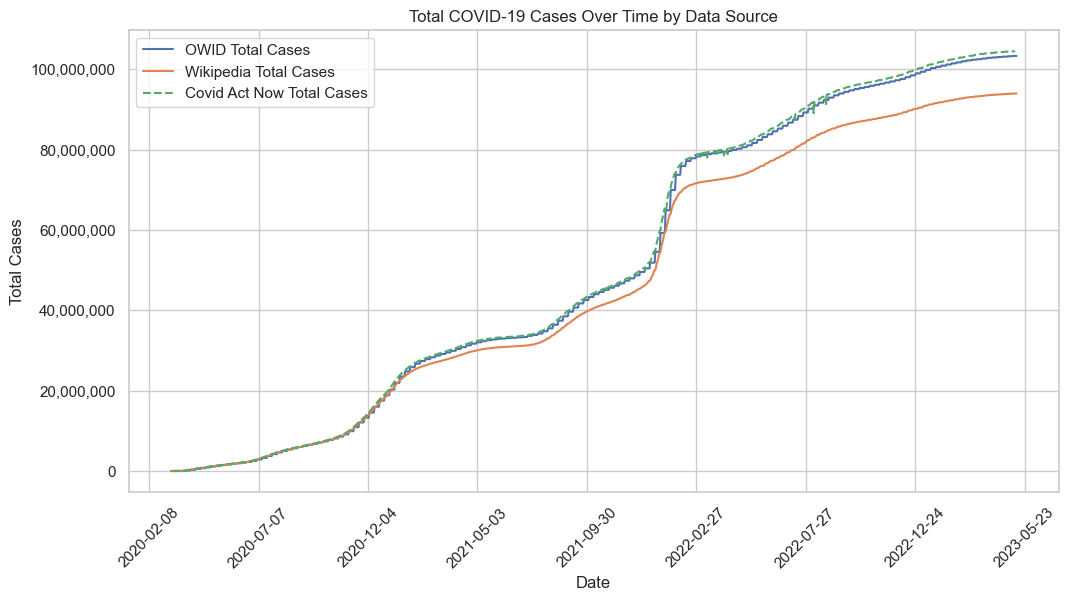

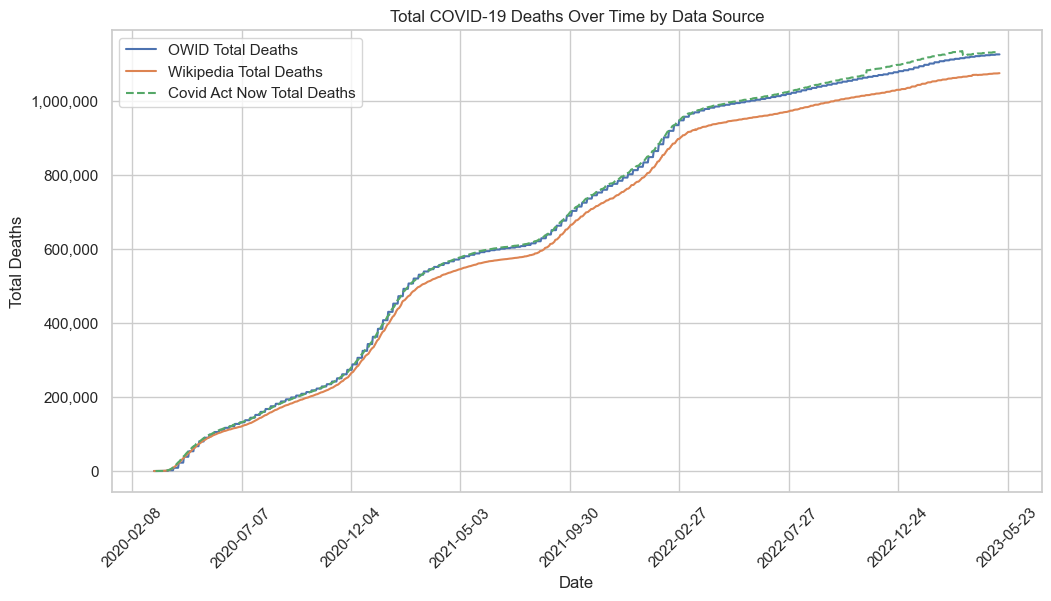

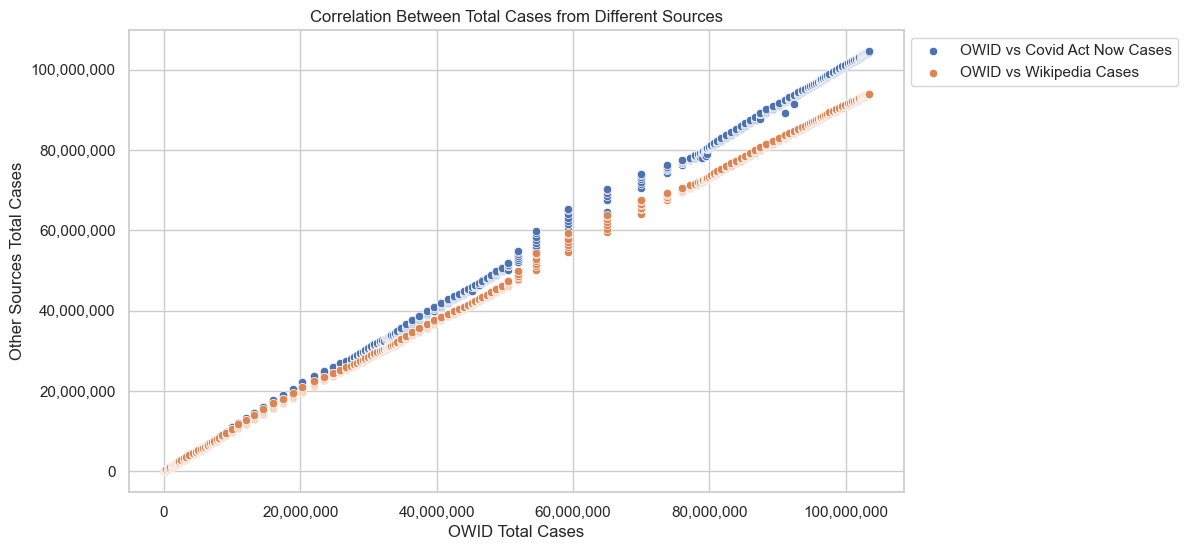

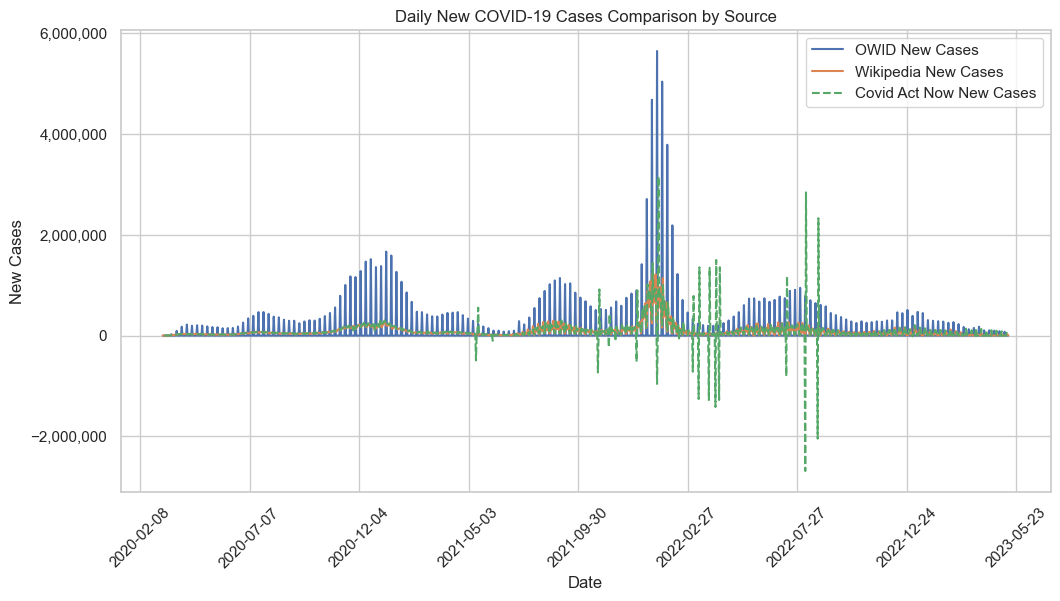

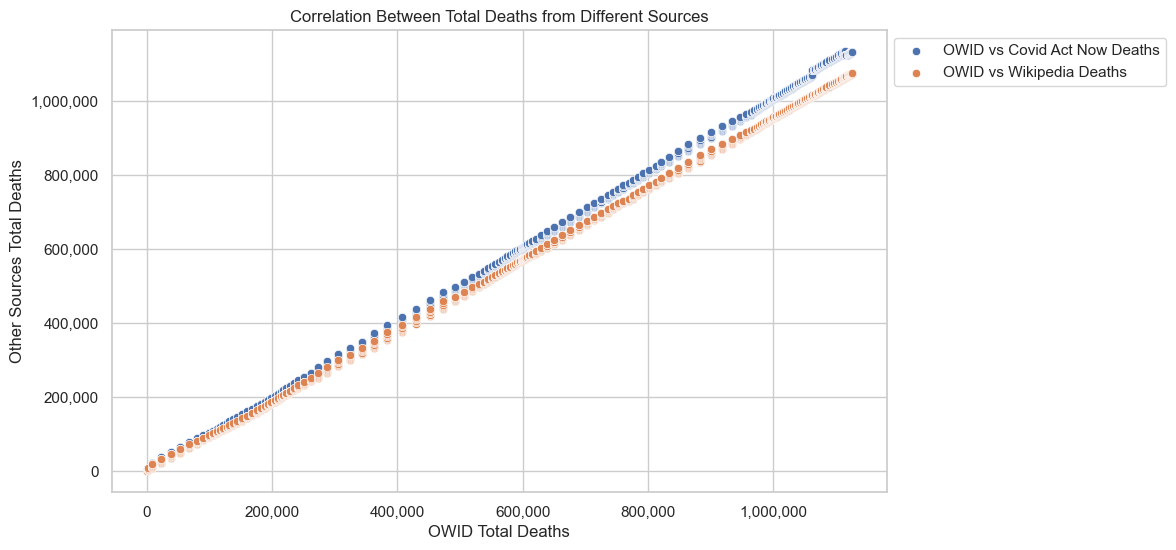

In [6]:
#  Ensure dates are parsed correctly and sort by Date for visualization
merged_data['Date'] = pd.to_datetime(merged_data['Date'], errors='coerce')  # Coerce invalid dates to NaT
merged_data.dropna(subset=['Date'], inplace=True)  # Drop rows with invalid dates
merged_data.sort_values(by='Date', inplace=True)

# Set style for visuals
sns.set_theme(style="whitegrid")

def format_plot(ax, x_date_format='%Y-%m-%d'):
    ax.xaxis.set_major_locator(plt.MaxNLocator(10))  # Limit x-axis ticks for readability
    ax.xaxis.set_major_formatter(DateFormatter(x_date_format))
    ax.yaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.0f}'))  # Format y-axis to avoid scientific notation
    plt.xticks(rotation=45)

# 1. Total Cases Over Time by Source (Cumulative)
plt.figure(figsize=(12, 6))
ax = sns.lineplot(data=merged_data, x='Date', y='owid_total_cases', label='OWID Total Cases')
sns.lineplot(data=merged_data, x='Date', y='wiki_total_cases', label='Wikipedia Total Cases')
sns.lineplot(data=merged_data, x='Date', y='act_now_total_cases', label='Covid Act Now Total Cases', linestyle='--')
format_plot(ax)
plt.title("Total COVID-19 Cases Over Time by Data Source")
plt.xlabel("Date")
plt.ylabel("Total Cases")
plt.legend()
plt.show()

# 2. Total Deaths Over Time by Source
plt.figure(figsize=(12, 6))
ax = sns.lineplot(data=merged_data, x='Date', y='owid_total_deaths', label='OWID Total Deaths')
sns.lineplot(data=merged_data, x='Date', y='wiki_total_deaths', label='Wikipedia Total Deaths')
sns.lineplot(data=merged_data, x='Date', y='act_now_total_deaths', label='Covid Act Now Total Deaths', linestyle='--')
format_plot(ax)
plt.title("Total COVID-19 Deaths Over Time by Data Source")
plt.xlabel("Date")
plt.ylabel("Total Deaths")
plt.legend()
plt.show()

# 3. Correlation Between Total Cases from Different Sources
plt.figure(figsize=(10, 6))
ax = sns.scatterplot(data=merged_data, x='owid_total_cases', y='act_now_total_cases', label='OWID vs Covid Act Now Cases')
sns.scatterplot(data=merged_data, x='owid_total_cases', y='wiki_total_cases', label='OWID vs Wikipedia Cases')
plt.title("Correlation Between Total Cases from Different Sources")
plt.xlabel("OWID Total Cases")
plt.ylabel("Other Sources Total Cases")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
ax.xaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.0f}'))
ax.yaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.0f}'))
plt.show()

# 4. Daily New Cases Comparison by Source
merged_data['owid_New_Cases'] = merged_data['owid_total_cases'].diff()
merged_data['wiki_New_Cases'] = merged_data['wiki_total_cases'].diff()
merged_data['act_now_New_Cases'] = merged_data['act_now_total_cases'].diff()

plt.figure(figsize=(12, 6))
ax = sns.lineplot(data=merged_data, x='Date', y='owid_New_Cases', label='OWID New Cases')
sns.lineplot(data=merged_data, x='Date', y='wiki_New_Cases', label='Wikipedia New Cases')
sns.lineplot(data=merged_data, x='Date', y='act_now_New_Cases', label='Covid Act Now New Cases', linestyle='--')
format_plot(ax)
plt.title("Daily New COVID-19 Cases Comparison by Source")
plt.xlabel("Date")
plt.ylabel("New Cases")
plt.legend()
plt.show()

# 5. Total Deaths Correlation Across Sources
plt.figure(figsize=(10, 6))
ax = sns.scatterplot(data=merged_data, x='owid_total_deaths', y='act_now_total_deaths', label='OWID vs Covid Act Now Deaths')
sns.scatterplot(data=merged_data, x='owid_total_deaths', y='wiki_total_deaths', label='OWID vs Wikipedia Deaths')
plt.title("Correlation Between Total Deaths from Different Sources")
plt.xlabel("OWID Total Deaths")
plt.ylabel("Other Sources Total Deaths")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
ax.xaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.0f}'))
ax.yaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.0f}'))
plt.show()




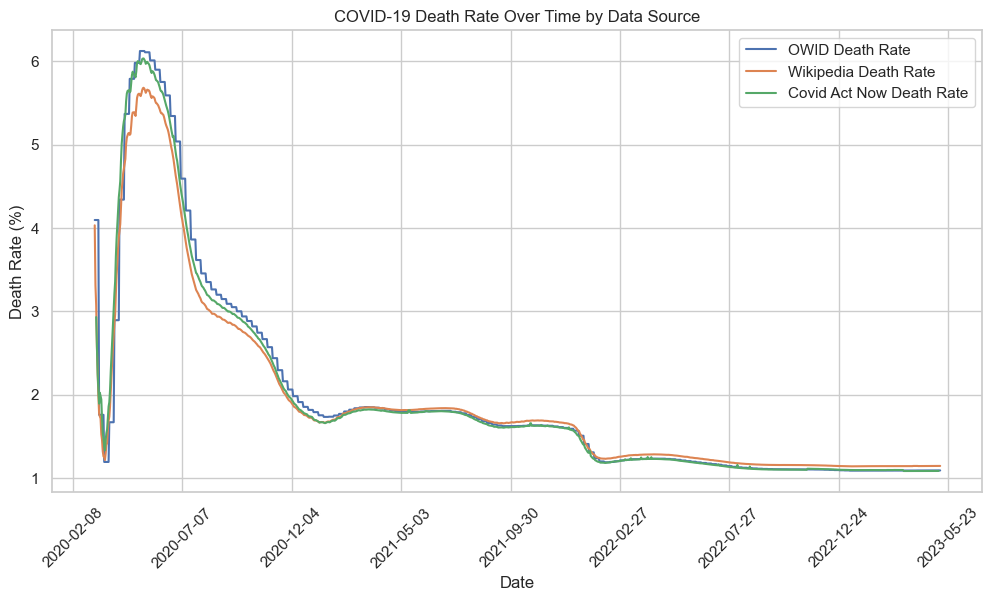

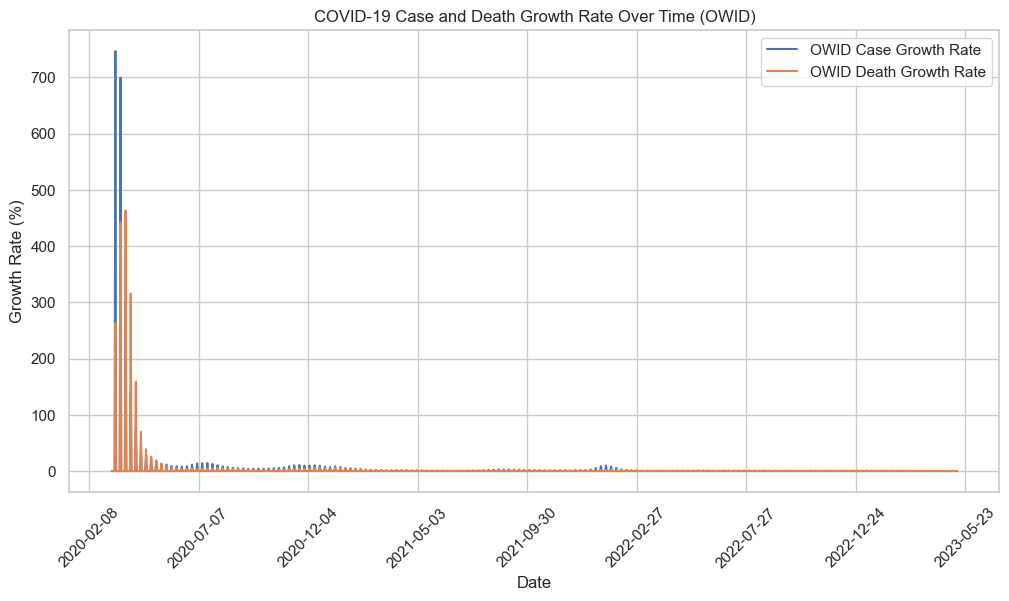

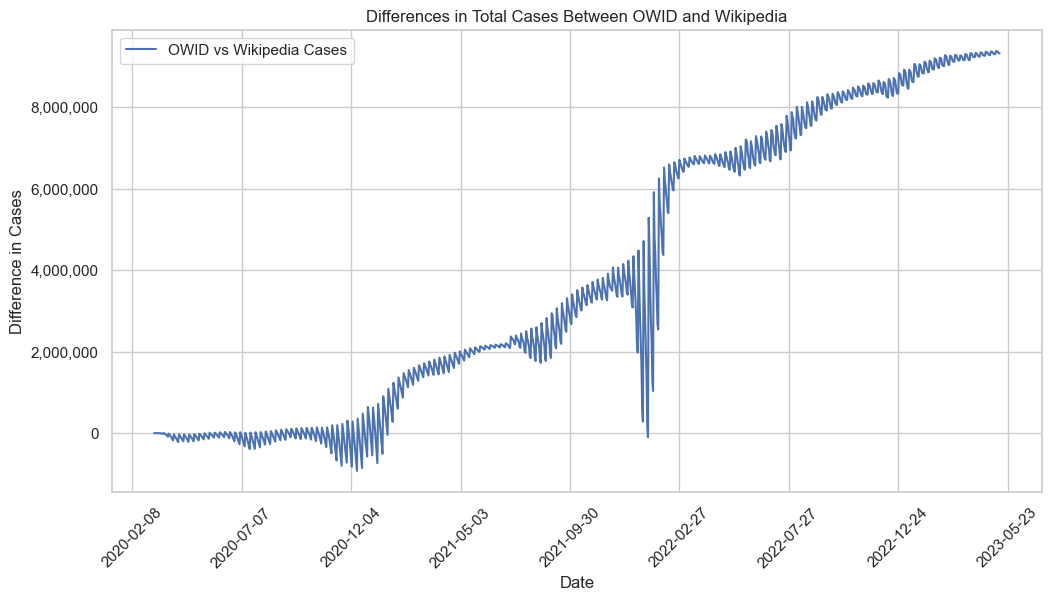

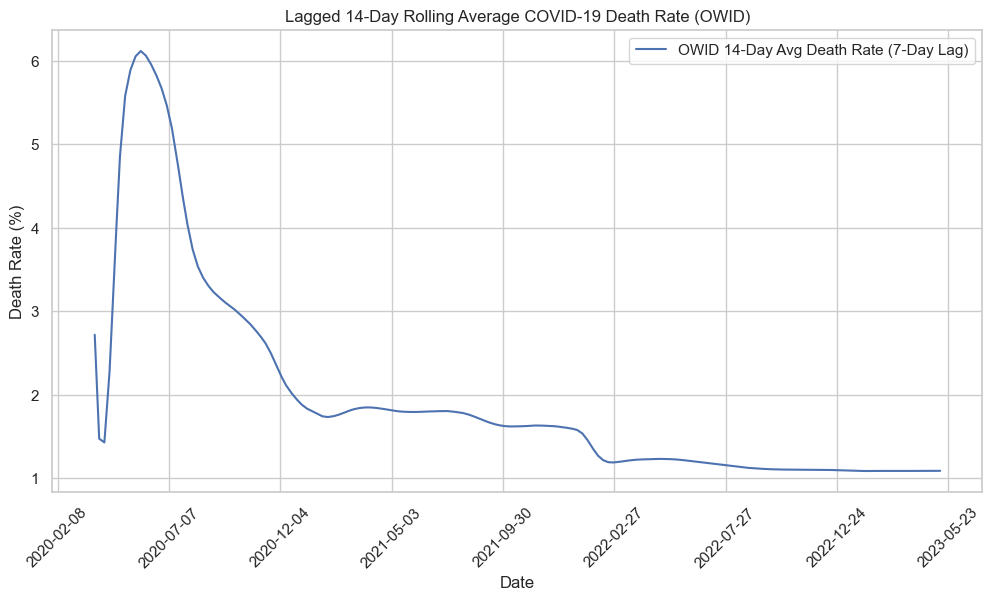

In [8]:
# Calculate death rate as (total_deaths / total_cases) * 100
merged_data['owid_death_rate'] = (merged_data['owid_total_deaths'] / merged_data['owid_total_cases']) * 100
merged_data['wiki_death_rate'] = (merged_data['wiki_total_deaths'] / merged_data['wiki_total_cases']) * 100
merged_data['act_now_death_rate'] = (merged_data['act_now_total_deaths'] / merged_data['act_now_total_cases']) * 100

# Plot death rate over time for each dataset
plt.figure(figsize=(12, 6))
ax = sns.lineplot(data=merged_data, x='Date', y='owid_death_rate', label='OWID Death Rate')
sns.lineplot(data=merged_data, x='Date', y='wiki_death_rate', label='Wikipedia Death Rate')
sns.lineplot(data=merged_data, x='Date', y='act_now_death_rate', label='Covid Act Now Death Rate')
format_plot(ax)
plt.title("COVID-19 Death Rate Over Time by Data Source")
plt.xlabel("Date")
plt.ylabel("Death Rate (%)")
plt.legend()
plt.show()


# Calculate daily percentage growth rates for cases and deaths
merged_data['owid_case_growth'] = merged_data['owid_total_cases'].pct_change() * 100
merged_data['owid_death_growth'] = merged_data['owid_total_deaths'].pct_change() * 100

# Plot the growth rate comparison
plt.figure(figsize=(12, 6))
ax = sns.lineplot(data=merged_data, x='Date', y='owid_case_growth', label='OWID Case Growth Rate')
sns.lineplot(data=merged_data, x='Date', y='owid_death_growth', label='OWID Death Growth Rate')
format_plot(ax)
plt.title("COVID-19 Case and Death Growth Rate Over Time (OWID)")
plt.xlabel("Date")
plt.ylabel("Growth Rate (%)")
plt.legend()
plt.show()

# Calculate discrepancies between data sources
merged_data['diff_cases_owid_wiki'] = merged_data['owid_total_cases'] - merged_data['wiki_total_cases']
merged_data['diff_deaths_owid_wiki'] = merged_data['owid_total_deaths'] - merged_data['wiki_total_deaths']

# Plot differences in cases
plt.figure(figsize=(12, 6))
ax = sns.lineplot(data=merged_data, x='Date', y='diff_cases_owid_wiki', label='OWID vs Wikipedia Cases')
format_plot(ax)
plt.title("Differences in Total Cases Between OWID and Wikipedia")
plt.xlabel("Date")
plt.ylabel("Difference in Cases")
plt.legend()
plt.show()



# Calculate a 14-day rolling average of death rate for OWID, with a 7-day lag
merged_data['owid_death_rate_14d_avg'] = merged_data['owid_death_rate'].shift(7).rolling(window=14).mean()

# Plot the lagged rolling average death rate
plt.figure(figsize=(12, 6))
ax = sns.lineplot(data=merged_data, x='Date', y='owid_death_rate_14d_avg', label='OWID 14-Day Avg Death Rate (7-Day Lag)')
format_plot(ax)
plt.title("Lagged 14-Day Rolling Average COVID-19 Death Rate (OWID)")
plt.xlabel("Date")
plt.ylabel("Death Rate (%)")
plt.legend()
plt.show()